In [280]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import LinearScale, LogScale
from scipy import signal, special
from mockin import *


def plot_filter(ax1, coeffs, sample_freq, filter_name, center_freq=None, log_plot=True,
                phase_graph=False, delay_graph=False, max_bpm=300):
    b, a = coeffs
    space = np.logspace(-2, math.log10(max_bpm / 60),
                        1000) if log_plot else np.linspace(0, max_bpm / 60, 1000) + 1/1000
    w, h = signal.freqz(b, a, worN=space, fs=sample_freq)
    w_bpm = 60 * w

    ax1.set_title(filter_name + ' filter characteristics')

    y1 = 20*np.log10(np.abs(h))
    if log_plot:
        ax1.semilogx(w_bpm, y1, color='blue')
    else:
        ax1.plot(w_bpm, y1, color='blue')
    ax1.axhline(0, color='blue', linestyle='--')
    ax1.axhline(-3, color='blue', linestyle=':')  # -3 dB magnitude
    if center_freq:
        ax1.axvline(center_freq, color='blue',
                    linestyle=':')  # cutoff frequency
    ax1.set_xlabel('Frequency [BPM]')
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(which='both', axis='both')

    if phase_graph:
        ax2 = ax1.twinx()
        y2 = np.angle(h)
        if log_plot:
            ax2.semilogx(w_bpm, y2, color='green')
        else:
            ax2.plot(w_bpm, y2, color='green')
        ax2.axhline(0, color='green', linestyle='--')
        ax2.set_ylabel(None)
        ax2.set_yticks([])
        ax2.set_ylim(-np.pi, np.pi)
        ax2.margins(0, 0)

    if delay_graph:
        ax3 = ax1.twinx()
        phase = (2 * np.pi + np.angle(h)) % (2 * np.pi)
        y3 = 1000 * phase / (2 * np.pi * w)
        if log_plot:
            ax3.semilogx(w_bpm, y3, color='orange')
        else:
            ax3.plot(w_bpm, y3, color='orange')
        ax3.axhline(0, color='orange', linestyle='--')
        ax3.set_ylim(-10, 110)
        ax3.margins(0, 0.1)
        ax3.set_ylabel('Group delay [ms]')


# Tuned constants for generation

In [281]:
#sample_freq = input.sample_freq
sample_freq = 200

comb_q = 0.90

dc_reject_coeffs = signal.butter(1, 0.1, fs=sample_freq, btype='highpass')
print("{ %s }," % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[0])),))
print("{ %s }" % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[1])),))

comb_buf_size = 256
comb_extra_buf = 8

lowest_bpm = 83
highest_bpm = 200


{ 0.998431665916719f, -0.998431665916719f },
{ 1.0f, -0.996863331833438f }


# Signal chain generator

This doesn't generate an actual signal chain quite yet, we'll use this generator multiple times with different parameters to compare performance.

In [282]:
class IirFilter:
    pass


class SignalChain:
    dc_reject_coeffs: tuple[list[float], list[float]]
    comb_q: float
    lowest_bpm: float
    highest_bpm: float
    comb_coeffs: list
    comb_memory: int

    def __init__(self, dc_reject_coeffs=dc_reject_coeffs, comb_q=comb_q, lowest_bpm=lowest_bpm,
                 highest_bpm=highest_bpm, comb_buf_size=comb_buf_size, comb_extra_buf=comb_extra_buf):
        self.dc_reject_coeffs = dc_reject_coeffs

        self.comb_q = comb_q
        self.lowest_bpm = lowest_bpm
        self.highest_bpm = highest_bpm
        self.comb_buf_size = comb_buf_size
        self.comb_extra_buf = comb_extra_buf

        self.comb_coeffs = [self.filter_defn(
            period, decimation) for period, decimation in self.filter_periods()]
        self.comb_memory = len(self.comb_coeffs) * self.comb_buf_size * 4

    def filter_periods(self):
        global sample_freq

        def calc_decimation(filter_period: int):
            buf_remain = self.comb_buf_size - self.comb_extra_buf
            return max(1, (filter_period + buf_remain - 1) // buf_remain)

        def next_filter_period(filter_period: int):
            decimation = calc_decimation(filter_period)
            return filter_period + decimation

        period = math.floor(sample_freq * 60 / highest_bpm + 0.5)
        last_distance = highest_bpm - lowest_bpm
        while True:
            decimation = calc_decimation(period)
            yield (period // decimation, decimation,)
            period += decimation
            distance = abs(sample_freq * 60 / period - lowest_bpm)
            if distance > last_distance:
                break
            last_distance = distance

    def filter_defn(self, period, decimation):
        global sample_freq

        real_period = period * decimation
        bpm = sample_freq * 60 / (real_period)
        name = "%.4g BPM" % (bpm,)
        k = bpm / highest_bpm
        q = self.comb_q
        coeffs = ([math.sqrt(k) * (1 - q) / decimation] * decimation,
                  [1] + ([0] * (period * decimation - 1)) + [-q],)
        return (name, period, decimation, coeffs)


# Check DC rejection filter characteristics

What we're looking for here is that (a) DC is rejected (0 response at 0Hz), which this graph technically won't show because that would be -inf, so the plot leaves off exactly 0Hz, but you should see a fast trend that direction; and (b) the group delay in ms is below say 20 at the lowest bpm frequency we care about, which is 80ish.

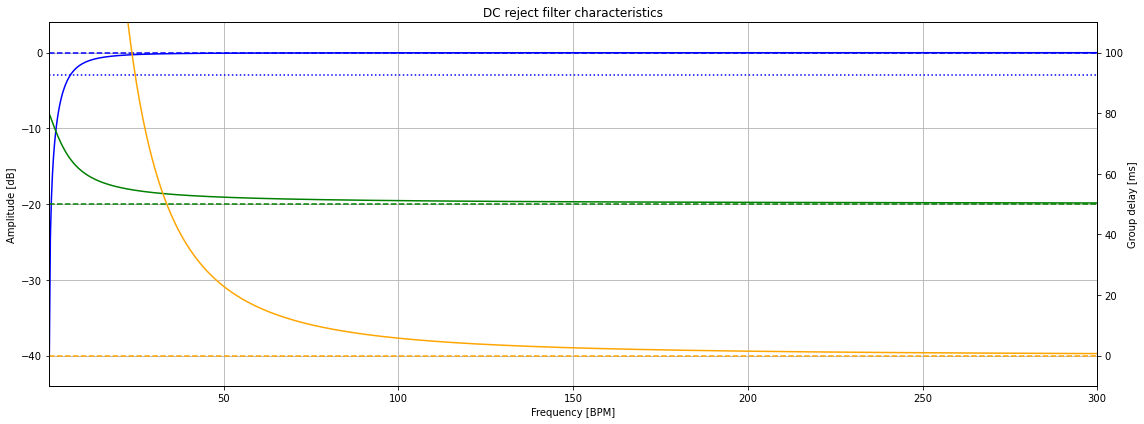

In [283]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
plot_filter(ax, dc_reject_coeffs, sample_freq, 'DC reject',
            log_plot=False, phase_graph=True, delay_graph=True)
fig.tight_layout()
plt.show()

# Check comb filter spacing, discrimination

This is a plot of the frequency response of the comb filters for the 2 highest and 2 lowest BPM detection bins. Note that the lower frequency filters slightly reduce the power of the output, this is on purpose because there is some overlap between filters that are harmonically related. For example, a filter tuned to 90bpm will pick up a signal at 180bpm, but it will additionally pick up some energy from noise at the intermediate harmonics, and so it might show a (spuriously) better return than the actual 180bpm comb filter. To counteract this we artificially reduce the output of the lower frequency filters.

('200 BPM', 60, 1)


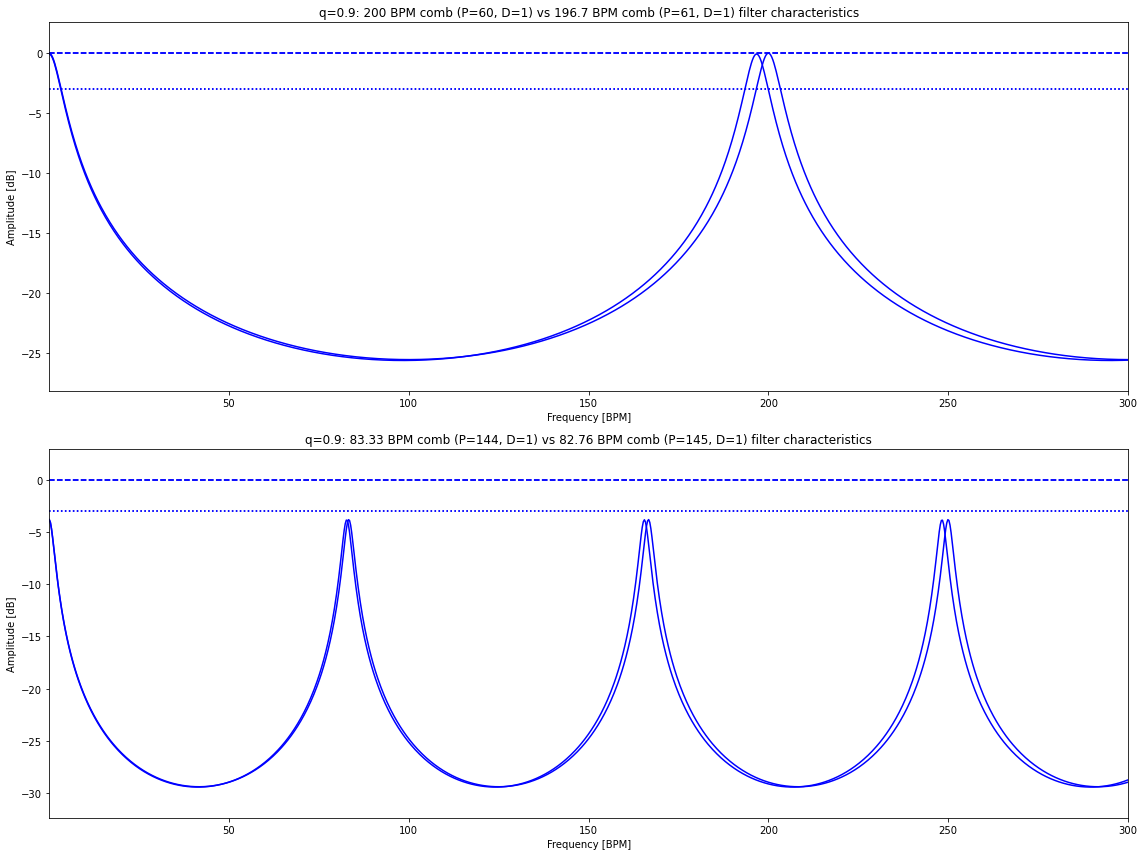

In [284]:
comb_coeffs = SignalChain().comb_coeffs

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
print(tuple(comb_coeffs[0][0:3]))
plot_filter(ax1, comb_coeffs[0][-1], sample_freq, '', log_plot=False)
plot_filter(ax1, comb_coeffs[1][-1], sample_freq, 'q=%g: %s comb (P=%g, D=%g) vs %s comb (P=%g, D=%g)' %
            tuple((comb_q,) + comb_coeffs[0][0:3] + comb_coeffs[1][0:3]), log_plot=False)
plot_filter(ax2, comb_coeffs[-2][-1], sample_freq, '', log_plot=False)
plot_filter(ax2, comb_coeffs[-1][-1], sample_freq, 'q=%g: %s comb (P=%g, D=%g) vs %s comb (P=%g, D=%g)' %
            tuple((comb_q,) + comb_coeffs[-2][0:3] + comb_coeffs[-1][0:3]), log_plot=False)
fig.tight_layout()
plt.show()

del comb_coeffs


# Prepare the test data

In [285]:
y_148 = InputMock("sample124bpm-200hz.txt", 200, loop_count=10).read_all_samples()
y_174 = InputMock("sample174bpm-sloppy-200hz.txt", 200, loop_count=10).read_all_samples()
y_148_174 = (InputMock("sample124bpm-200hz.txt", 200, loop_count=3).read_all_samples()
    + InputMock("sample174bpm-sloppy-200hz.txt", 200, loop_count=3).read_all_samples()
    + InputMock("sample124bpm-200hz.txt", 200, loop_count=3).read_all_samples())

# y = y_148_174[17000:19000]
# plt.plot(range(len(y)), y)
# plt.show()


Memory required for comb filter buffers: 88064
27093 27093
(86, 27093)


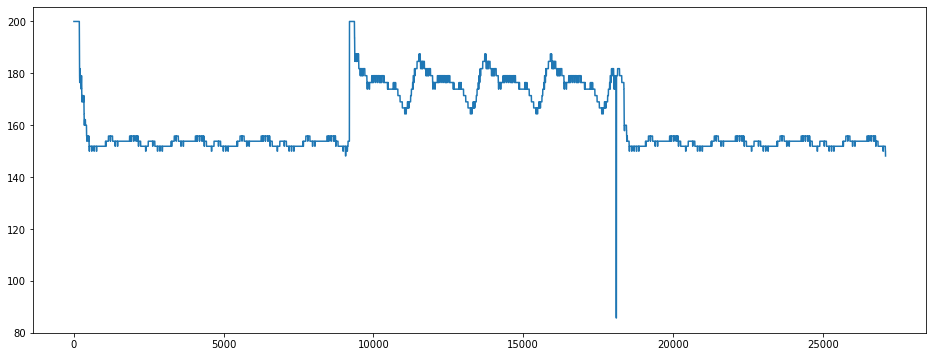

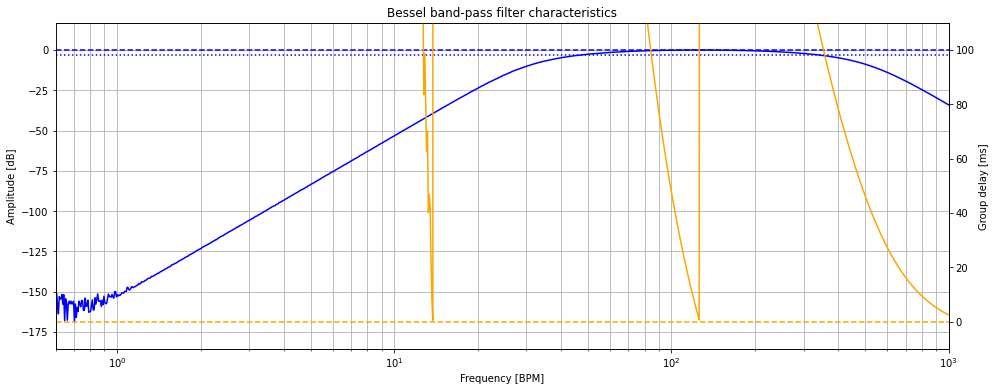

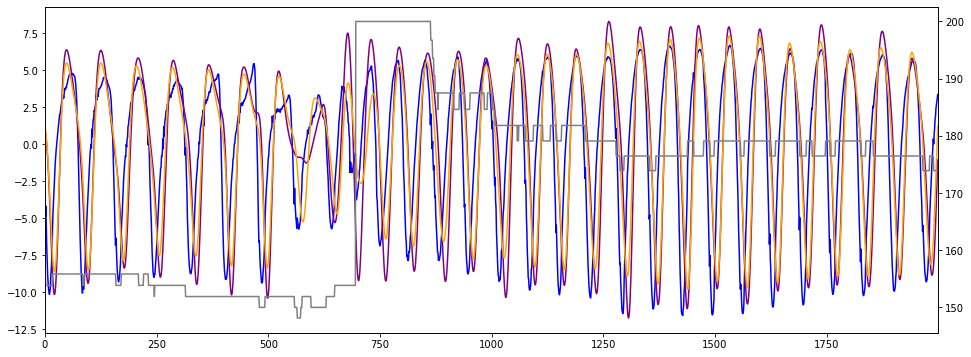

In [303]:
sc = SignalChain(comb_q=0.6)
comb_coeffs = sc.comb_coeffs
print('Memory required for comb filter buffers:', sc.comb_memory)


def apply_filter(coeffs, x, steady_state=None):
    b, a = coeffs
    zi = None
    if steady_state != None:
        zi = [-steady_state] * (len(a) - 1)
        y, zf = signal.lfilter(b, a, x, zi=zi)
    else:
        y = signal.lfilter(b, a, x)
    return y


dc_rej_y = apply_filter(dc_reject_coeffs, y_148_174, -9.8)
print(len(y_148_174), len(dc_rej_y))

comb_ys = np.zeros((len(comb_coeffs), len(y_148_174),))
power_ys = np.zeros((len(comb_coeffs), len(y_148_174),))
bpm_map = [0] * len(comb_coeffs)
print(comb_ys.shape)
for i, (name, period, decimation, coeffs,) in enumerate(comb_coeffs):
    bpm_map[i] = sample_freq * 60 / (period * decimation)
    y = apply_filter(coeffs, dc_rej_y)
    ext_period = period * decimation
    np.copyto(comb_ys[i], y)
    np.copyto(power_ys[i], apply_filter(([1 / ext_period] * ext_period, [1],), y * y))

ax = plt.figure(figsize=(16, 6)).add_subplot()
select_ys = power_ys.argmax(0)
selected_ys = [comb_ys[int(select_ys[i]),i] for i in range(len(select_ys))]
bpm_ys = list(map(lambda i: bpm_map[i], select_ys))
ax.plot(range(len(bpm_ys)), bpm_ys)
plt.show()

ax = plt.figure(figsize=(16, 6)).add_subplot()
#lp_post_coeffs = signal.cheby1(5, 1, 10, 'lowpass', fs=sample_freq)
lp_post_coeffs = signal.bessel(5, (80/60, 200/60), 'bandpass', fs=sample_freq, norm='delay')
plot_filter(ax, lp_post_coeffs, sample_freq, 'Bessel band-pass', max_bpm=1000, delay_graph=True)
plt.show()

ax = plt.figure(figsize=(16, 6)).add_subplot()
p, q = 8500, 10500
y = selected_ys[p:q]
ax.set_xmargin(0)
ax.plot(range(len(y)), y, color='blue')
ax.plot(range(len(y)), apply_filter(lp_post_coeffs, dc_rej_y)[p:q], color='purple')
ax.plot(range(len(y)), apply_filter(lp_post_coeffs, selected_ys)[p:q], color='orange')
#ax.plot(range(len(y)), dc_rej_y[p:q])
#ax.plot(range(len(y)), np.diff(selected_ys)[p:q])
#ax.plot(range(len(y)), np.diff(apply_filter(lp_post_coeffs, selected_ys))[p:q])
ax2 = ax.twinx()
ax2.plot(range(len(y)), bpm_ys[p:q], color='gray')
plt.show()

# softmax_ys = special.softmax(comb_ys, 0)
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(projection='3d')
# for i, y in enumerate(softmax_ys):
#     ax.plot(range(len(y)), y, zs=(len(comb_ys) - 1 - i), zdir='y')

# ax = fig.add_subplot(projection='3d')
# for i, y in enumerate(comb_ys):
#     ax.plot(range(len(y)), y, zs=(len(comb_ys) - 1 - i), zdir='y')

# y = comb_ys[0][1]
# plt.plot(range(len(y)), y)

# ax.set_xlabel('Time (samples)')
# ax.set_ylabel('Value')
# ax.set_zlabel('Filter (BPM)')
